In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

from collections import deque

statistics = {
    'id':[],
    'arrive_time':[],
    'corona':[],
    'hall_service_time':[],
    'room':[],
    'room_arrive_time':[],
    'room_service_time':[],
    'hospital_left':[],
}
with open('input.txt', 'r') as file:
    input_lines = [line.strip() for line in file]

In [2]:
class Person():
    def __init__(self, arrive_time, corona, alpha, id, room_num):
        self.id = id
        self.arrive_time = arrive_time
        self.corona = corona
        self.hall_service_start_time = 0  # hall_service_start_time
        self.room = 0
        self.room_arrive_time = 0
        self.room_service_time = 0
        self.hospital_left = 0
        t_t = np.random.exponential(alpha)
        self.recipient_waiting_time = 0
        self.fixed_wating_time = t_t
        self.room_waiting_time = [0.0 for i in range(room_num)]


class Recipient():
    def __init__(self, landa, last_service):
        self.landa = landa
        self.last_service = last_service

    def __lt__(self, other):
        return self.last_service < other.last_service

    def __eq__(self, other):
        return self.last_service == other.last_service

    def creat_random(self):
        return np.random.exponential(self.landa)
    # return random.randint(3,12)


class Hall():

    def __init__(self, time, number):
        self.time = time  # in which time it is
        self.number = number  # id
        self.corona = deque([])
        self.non_corona = deque([])
        self.recipient = []

    def __lt__(self, other):
        len(self.corona) + len(self.non_corona) < len(other.corona) + len(other.non_corona)


    def min_recip(self):
        t = min(self.recipient)
        return t

    def add(self, pers):
        if (pers.corona == True):
            self.corona.append(pers)
        else:
            self.non_corona.append(pers)

    def num(self):
        return len(self.corona) + len(self.non_corona)

    def update(self):
        self.time = self.min_recip().last_service


def rec_1(recp, pers, t):  # for recipient | t is for
    t_1 = recp.creat_random()
    pers.hall_service_start_time = max(recp.last_service, pers.arrive_time)
    pers.room_arrive_time = pers.hall_service_start_time + t_1
    recp.last_service = pers.hall_service_start_time + t_1


def rec_2(recp, pers, t):  # for doctors room
    t_1 = recp.creat_random()
    pers.room_service_time = max(t, pers.room_arrive_time)
    pers.hospital_left = max(t, pers.room_arrive_time) + t_1
    recp.last_service = max(t, pers.room_arrive_time) + t_1


def accept_room(hall):
    pers = 0
    if (len(hall.corona) == 0):
        pers = hall.non_corona.popleft()
    elif (len(hall.non_corona) == 0):
        pers = hall.corona.popleft()
    elif (hall.time >= max(hall.corona[0].arrive_time, hall.non_corona[0].arrive_time)):
        pers = hall.corona.popleft()
    elif (hall.corona[0].arrive_time >= hall.non_corona[0].arrive_time):
        pers = hall.non_corona.popleft()
    else:
        pers = hall.corona.popleft()
    recp = hall.min_recip()
    time_to_visit = max(recp.last_service, pers.room_arrive_time)
    #     pers.waiting_time = pers.waiting_time - (time_to_visit - pers.room_arrive_time)
    #     if (pers.waiting_time < 0):
    pers.room_waiting_time[hall.number - 1] += (time_to_visit - pers.room_arrive_time)
    #     room_waiting_time = pers.room_waiting_time.get(hall.number, False)
    #     if room_waiting_time:
    #         pers.room_waiting_time[hall.number] = room_waiting_time + time_to_visit - pers.room_arrive_time
    #     else:
    #         pers.room_waiting_time[hall.number] = time_to_visit - pers.room_arrive_time

    if ((sum(pers.room_waiting_time) + pers.recipient_waiting_time) > pers.fixed_wating_time):
        return hall
    rec_2(recp, pers, recp.last_service)
    hall.update()


def work_room_recp_untill_t(room, t):
    while (room.time <= t and room.num() > 0):
        accept_room(room)


def accept(hall, rooms):
    pers = 0
    if (len(hall.corona) == 0):
        pers = hall.non_corona.popleft()
    elif (len(hall.non_corona) == 0):
        pers = hall.corona.popleft()
    elif (hall.time >= max(hall.corona[0].arrive_time, hall.non_corona[0].arrive_time)):
        pers = hall.corona.popleft()
    elif (hall.corona[0].arrive_time >= hall.non_corona[0].arrive_time):
        pers = hall.non_corona.popleft()
    else:
        pers = hall.corona.popleft()
    recp = hall.min_recip()
    time_to_visit = max(recp.last_service, pers.arrive_time)
    #     pers.waiting_time = pers.waiting_time - (time_to_visit - pers.arrive_time )
    #     if (pers.waiting_time < 0):
    pers.recipient_waiting_time += (time_to_visit - pers.arrive_time)
    if ((sum(pers.room_waiting_time) + pers.recipient_waiting_time) > pers.fixed_wating_time):
        return hall
    rec_1(recp, pers, recp.last_service)
    selected_room =rooms[0]
    for i in range(len(rooms)):
        work_room_recp_untill_t(rooms[i], pers.room_arrive_time)
    for i in range(len(rooms)):
        if (len(selected_room.corona) + len(selected_room.non_corona) > len(rooms[i].corona) + len(rooms[i].non_corona)):
            selected_room = rooms[i]
    pers.room = selected_room.number
    selected_room.add(pers)
    hall.update()

    return hall


def work_hall_recp_untill_t(hall1, t, rooms):
    while (hall1.time <= t and hall1.num() > 0):
        accept(hall1, rooms)


# def main():
#     rooms = []
#     M =0
#     landa = 0
#     alpha = 0
#     miu = 0
#     inputs = []
#     for i in range(len(input_lines)):
#         inputs.append(list(map(str,input_lines[i].split())))

#     M = int(inputs[0][0])
#     landa = float(inputs[0][1])
#     alpha = float(inputs[0][2])
#     miu =float(inputs[0][3])
#     main_recp = Recipient(miu,0)
#     hall = Hall(0,M)
#     hall.recipient.append(main_recp)
#     for i in range(M):
#         room = Hall(0,i+1)
#         for j in range(len(inputs[i+1])):
#             recp = Recipient(float(inputs[i+1][j]) ,0)
#             room.recipient.append(recp)
#         rooms.append(room)

    
#     arrive_time = 0
#     perses = []
#     for i in range(10):
#         arrive_time = arrive_time + np.random.exponential(landa)
#         random_num = random.randint(1, 100)
#         pers = Person(arrive_time,random_num <= 10,alpha, i)
#         perses.append(pers)
# #         if(i % 100000 == 0):
# #             print(i)
#         hall.add(pers)
#         work_hall_recp_untill_t(hall,arrive_time, rooms)
#     current_time = hall.time
#     while(hall.num() >0):
#         current_time = current_time + 10000000
#         work_hall_recp_untill_t(hall, current_time, rooms)
#     for i in range(M):
#         while(rooms[i].num() > 0):
#             work_room_recp_untill_t(rooms[i],current_time)
#             current_time = current_time + 10000000
        
#     for i in range(len(perses)):
#         print("arrival time: " + str(perses[i].arrive_time )+ " \nservice sart time: " + str(perses[i].hall_service_start_time)+ " \nroom arrive time: " + str(perses[i].room_arrive_time)+ " \nroom service time: " + str(perses[i].room_service_time)+ " \ntime left hospital: " + str(perses[i].hospital_left) + " \nhas corona: " + str(perses[i].corona)+" \nwaiting time: " + str(perses[i].room_waiting_time + perses[i].recipient_waiting_time) + " \nroom assigned: " + str(perses[i].room)+" \nmax waiting time: " + str(perses[i].fixed_wating_time)  )
#         print('\n')




# main()
    


In [3]:
all_patient_num = 10000000

In [4]:
rooms = []
M =0
landa = 0
alpha = 0
miu = 0
inputs = []
for i in range(len(input_lines)):
    inputs.append(list(map(str,input_lines[i].split())))

M = int(inputs[0][0])
landa = float(inputs[0][1])
alpha = float(inputs[0][2])
miu =float(inputs[0][3])
main_recp = Recipient(miu,0)
hall = Hall(0,M)
hall.recipient.append(main_recp)
for i in range(M):
    room = Hall(0,i+1)
    for j in range(len(inputs[i+1])):
        recp = Recipient(float(inputs[i+1][j]),0) # here
        room.recipient.append(recp)
    rooms.append(room)


arrive_time = 0
perses = []
for i in range(all_patient_num):
    arrive_time = arrive_time + np.random.exponential(landa)
    random_num = random.randint(1, 100)
    pers = Person(arrive_time,random_num <= 10,alpha, i, M)
    perses.append(pers)
#         if(i % 100000 == 0):
#             print(i)
    hall.add(pers)
    work_hall_recp_untill_t(hall,arrive_time, rooms)
current_time = hall.time
while(hall.num() > 0):
    current_time = current_time + 100000000
    work_hall_recp_untill_t(hall, current_time, rooms)
for i in range(M):
    while(rooms[i].num() > 0):
        work_room_recp_untill_t(rooms[i],current_time)
        current_time = current_time + 100000000

In [5]:
# 0 id
# 1 arrive_time
# 2 corona
# 3 hall_service_start_time
# 4 room
# 5 room_arrive_time
# 6 room_service_time
# 7 hospital_left
# 8 recipient_waiting_time
# 9 fixed_wating_time
# 10 room_waiting_time
patients_data = np.zeros((all_patient_num, len(perses[0].__dict__.items())+M-1))
for p_id, patient in enumerate(perses):
    for attr_id, item in enumerate(patient.__dict__.items()):
        if type(item[1]) == list:
            for x in range(len(item[1])):
                patients_data[p_id][attr_id + x] = item[1][x]
        else:
            patients_data[p_id][attr_id] = item[1]

In [6]:
system_end_time = np.max(patients_data[:, 7])

sum_of_data = np.sum(patients_data[:], axis=0)

recipient_queue_len = sum_of_data[8]

room_queue_len = sum_of_data[10:]

in_hospital = patients_data[:, 7]>0

patinets_in_hospital = patients_data[in_hospital]

has_corona = (patinets_in_hospital[:, 2] > 0)

corona_patients = patinets_in_hospital[has_corona]

typical_patients = patinets_in_hospital[np.logical_not(has_corona)]

corona_patient_num = len(corona_patients)

patient_num = len(typical_patients)

sum_of_corona_data = np.sum(corona_patients[:], axis=0)

corona_time_in_system = sum_of_corona_data[7] - sum_of_corona_data[1]

corona_wait_time = np.sum(sum_of_corona_data[10:]) + sum_of_corona_data[8]

sum_of_typical_data = np.sum(typical_patients[:], axis=0)

time_in_system = sum_of_typical_data[7] - sum_of_typical_data[1]

wait_time = np.sum(sum_of_typical_data[10:]) + sum_of_typical_data[8]

patinets_not_in_hospital = patients_data[np.logical_not(in_hospital)]

leave_patient_num = len(patinets_not_in_hospital)

left_patients_has_corona = patinets_not_in_hospital[:, 2]>0

corona_patinets_not_in_hospital = patinets_not_in_hospital[left_patients_has_corona]

typical_patinets_not_in_hospital = patinets_not_in_hospital[np.logical_not(left_patients_has_corona)]

a = corona_patients[:, 8]

b = np.sum(corona_patients[:, 10:], axis=1)

variance = a + b

In [9]:
# time_in_system = 0
# patient_num = 0
# wait_time = 0

# corona_time_in_system = 0
# corona_patient_num = 0
# corona_wait_time = 0
# leave_patient_num = 0

# recipient_queue_len = 0
# room_queue_len = np.zeros((M), dtype=np.float64)
# system_end_time = 0
# variance = []
# for patient in perses:
#     system_end_time = max(system_end_time, patient.hospital_left)
#     recipient_queue_len += patient.recipient_waiting_time
#     room_queue_len += np.array(patient.room_waiting_time)
# #     room_queues.append(patient.room_waiting_time)
#     if patient.hospital_left > 0:
#         if patient.corona:
#             corona_patient_num += 1
#             corona_time_in_system += patient.hospital_left - patient.arrive_time
#             corona_wait_time += sum(patient.room_waiting_time) + patient.recipient_waiting_time
#             variance.append(sum(patient.room_waiting_time) + patient.recipient_waiting_time)
#         else:
#             patient_num += 1
#             time_in_system += patient.hospital_left - patient.arrive_time
#             wait_time += sum(patient.room_waiting_time) + patient.recipient_waiting_time
#     else:
#         leave_patient_num += 1

In [26]:
print("typical patient : ", time_in_system / patient_num)
print("corona patient : ", corona_time_in_system/corona_patient_num)
print("all patient : ", (corona_time_in_system+time_in_system)/(corona_patient_num+patient_num))
print("typical patient : ", wait_time / patient_num)
print("corona patient : ", corona_wait_time / corona_patient_num)
print("all patient : ", (corona_wait_time+wait_time) / (corona_patient_num+patient_num))
print(leave_patient_num / (patient_num + corona_patient_num))
print(recipient_queue_len / system_end_time)
print(room_queue_len / system_end_time)
print(np.sqrt(np.var(variance))*1.96*100)

typical patient :  0.4297042904256595
corona patient :  0.300603845062775
all patient :  0.41672643204757015
typical patient :  0.2128584796951491
corona patient :  0.08392891806882094
all patient :  0.19989779945247138
0.006745800913601679
1.0007545843716068
[1.45735207e-02 4.33919029e-06]
24.116731543002135


In [50]:
po = perses.copy()

In [31]:
room_data_x = []
room_data_y = []
for room_id, room in enumerate(rooms):
    doctor_data_y = []
    doctor_data_x = []
    for doctor_id in range(len(room.recipient)):
        old_landa = room.recipient[doctor_id].landa
        aux_y = []
        aux_x = []
        for x in range(int(1/old_landa)*10, 0, -2):
            room.recipient[doctor_id].landa = x / 10
            arrive_time = 0
            perses = []
            for i in range(1000):
                arrive_time = arrive_time + np.random.exponential(landa)
                random_num = random.randint(1, 100)
                pers = Person(arrive_time,random_num <= 10,alpha, i, M)
                perses.append(pers)
            #         if(i % 100000 == 0):
            #             print(i)
                hall.add(pers)
                work_hall_recp_untill_t(hall,arrive_time, rooms)
            current_time = hall.time
            while(hall.num() > 0):
                current_time = current_time + 10000000
                work_hall_recp_untill_t(hall, current_time, rooms)
            for i in range(M):
                while(rooms[i].num() > 0):
                    work_room_recp_untill_t(rooms[i],current_time)
                    current_time = current_time + 10000000
            
            room_queue_len = np.zeros((M), dtype=np.float64)
            system_end_time = 0
            for patient in perses:
                system_end_time = max(system_end_time, patient.hospital_left)
                room_queue_len += np.array(patient.room_waiting_time)
            
            aux_y.append(room_queue_len[room_id])
            aux_x.append(x / 10)
        doctor_data_x.append(aux_x)
        doctor_data_y.append(aux_y)
        room.recipient[doctor_id].landa = old_landa
    room_data_x.append(doctor_data_x)
    room_data_y.append(doctor_data_y)
            

In [ ]:
for i in range(len(rooms)):
    for j in range(len(rooms[i].recipient)):
        plt.plot(room_data_x[i][j], room_data_y[i][j])
        plt.xlabel("doctor {} of room {}".format(j, i))
        plt.show()

In [31]:
corona_response_time = [0 for i in range(10)]
response_time = [0 for i in range(10)]
for patient in perses:
    idx = int(np.floor((patient.room_arrive_time - patient.hall_service_start_time)/0.1))
    if patient.corona:    
        if idx >= len(corona_response_time):
            corona_response_time.extend([0 for i in range(idx - 5)])
            
        corona_response_time[idx] += 1
    else:
        if idx >= len(response_time):
            response_time.extend([0 for i in range(idx - 5)])
        response_time[idx] += 1

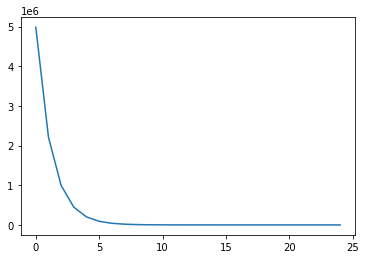

In [32]:
plt.plot(response_time)

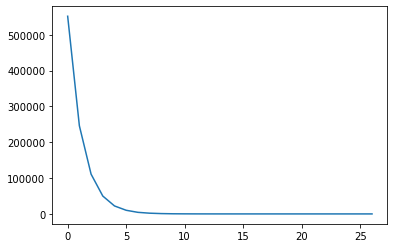

In [33]:
plt.plot(corona_response_time)

In [34]:
corona_waiting_time = [0 for i in range(10)]
waiting_time = [0 for i in range(10)]
for patient in perses:
    idx = int(np.floor((sum(patient.room_waiting_time) + patient.recipient_waiting_time)/0.1))
    if patient.corona:
        if idx >= len(corona_waiting_time):
            corona_waiting_time.extend([0 for i in range(idx - 5)])
        corona_waiting_time[idx] += 1
    else:
        if idx >= len(waiting_time):
            waiting_time.extend([0 for i in range(idx - 5)])
        waiting_time[idx] += 1

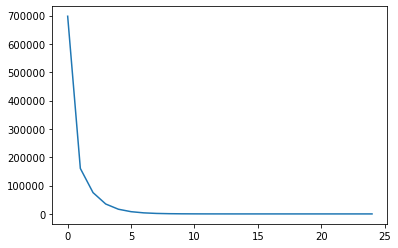

In [35]:
plt.plot(corona_waiting_time)

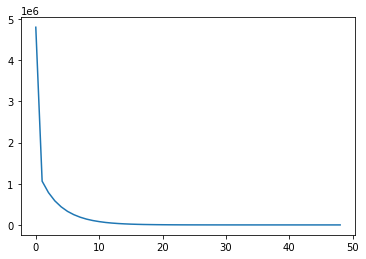

In [36]:
plt.plot(waiting_time)

In [76]:
a = np.ceil((corona_patients[:, 7] - corona_patients[:, 1])*3)
b = np.ceil((corona_patinets_not_in_hospital[:, 9])*3)

In [77]:
unique, counts = np.unique(a, return_counts=True)
unique_1, counts_1 = np.unique(b, return_counts=True)

In [78]:
corona_presence_statistic = np.zeros((max(int(unique[-1]), int(unique_1[-1]))))

In [79]:
for u, c in zip(unique, counts):
    corona_presence_statistic[int(u)-1] += c

for u, c in zip(unique_1, counts_1):
    corona_presence_statistic[int(u)-1] += c

In [80]:
c = np.ceil((typical_patients[:, 7] - typical_patients[:, 1])*3)
d = np.ceil((typical_patinets_not_in_hospital[:, 9])*3)

In [81]:
unique_2, counts_2 = np.unique(c, return_counts=True)
unique_3, counts_3 = np.unique(d, return_counts=True)

In [82]:
typical_presence_statistic = np.zeros((max(int(unique_2[-1]), int(unique_3[-1]))))

In [83]:
for u, c in zip(unique_2, counts_2):
    typical_presence_statistic[int(u)-1] += c

for u, c in zip(unique_3, counts_3):
    typical_presence_statistic[int(u)-1] += c

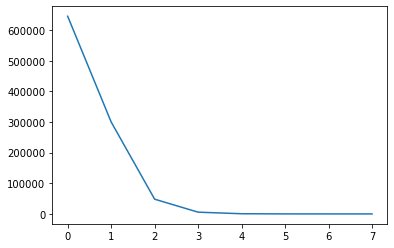

In [84]:
plt.plot(corona_presence_statistic)

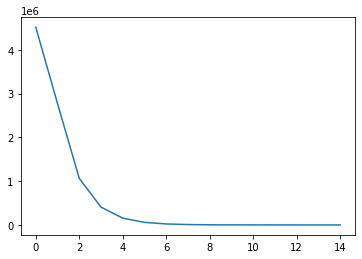

In [85]:
plt.plot(typical_presence_statistic)

In [9]:
from tqdm import tqdm

In [94]:
corona_precense_time = np.zeros(50, dtype=np.int)
precense_time = np.zeros(50, dtype=np.int)
for patient in tqdm(perses):
    if patient.hospital_left > 0:
        precense_length = patient.hospital_left - patient.arrive_time
    else:
        precense_length = patient.fixed_wating_time
    
#     if patient.corona:
#         if int(precense_length) >= len(corona_precense_time):
#             new = np.zeros(int(precense_length)+5, dtype=np.int)
#             new[:len(corona_precense_time)] += corona_precense_time
#             corona_precense_time = new 
        
#         corona_precense_time[int(precense_length)] += 1
    
#     else:
#         if int(precense_length) >= len(precense_time):
#             new = np.zeros(int(precense_length)+5, dtype=np.int)
#             new[:len(precense_time)] += precense_time
#             precense_time = new 
        
#         precense_time[int(precense_length)] += 1
    
    
    
    
    start = int(np.floor(patient.arrive_time/20))
    end = start + int(np.ceil(precense_length / 20))
    

    if patient.corona:
        if end >= len(corona_precense_time):
            new = np.zeros(end+5, dtype=np.int)
            new[:len(corona_precense_time)] += corona_precense_time
            corona_precense_time = new
        for i in range(start, end):
            corona_precense_time[i] += 1
    else:
        if end >= len(precense_time):
            new = np.zeros(end+5, dtype=np.int)
            new[:len(precense_time)] += precense_time
            precense_time = new
        for i in range(start, end):
            precense_time[i] += 1

100%|██████████████████████████████████████████████████████████████████| 10000000/10000000 [01:10<00:00, 142239.93it/s]


In [95]:
max_size = max(len(precense_time), len(corona_precense_time))
min_size = min(len(precense_time), len(corona_precense_time))

if len(precense_time) < len(corona_precense_time):
    all_precense_time = corona_precense_time.copy()
    all_precense_time[:len(precense_time)] += precense_time
else:
    all_precense_time = precense_time.copy()
    all_precense_time[:len(corona_precense_time)] += corona_precense_time

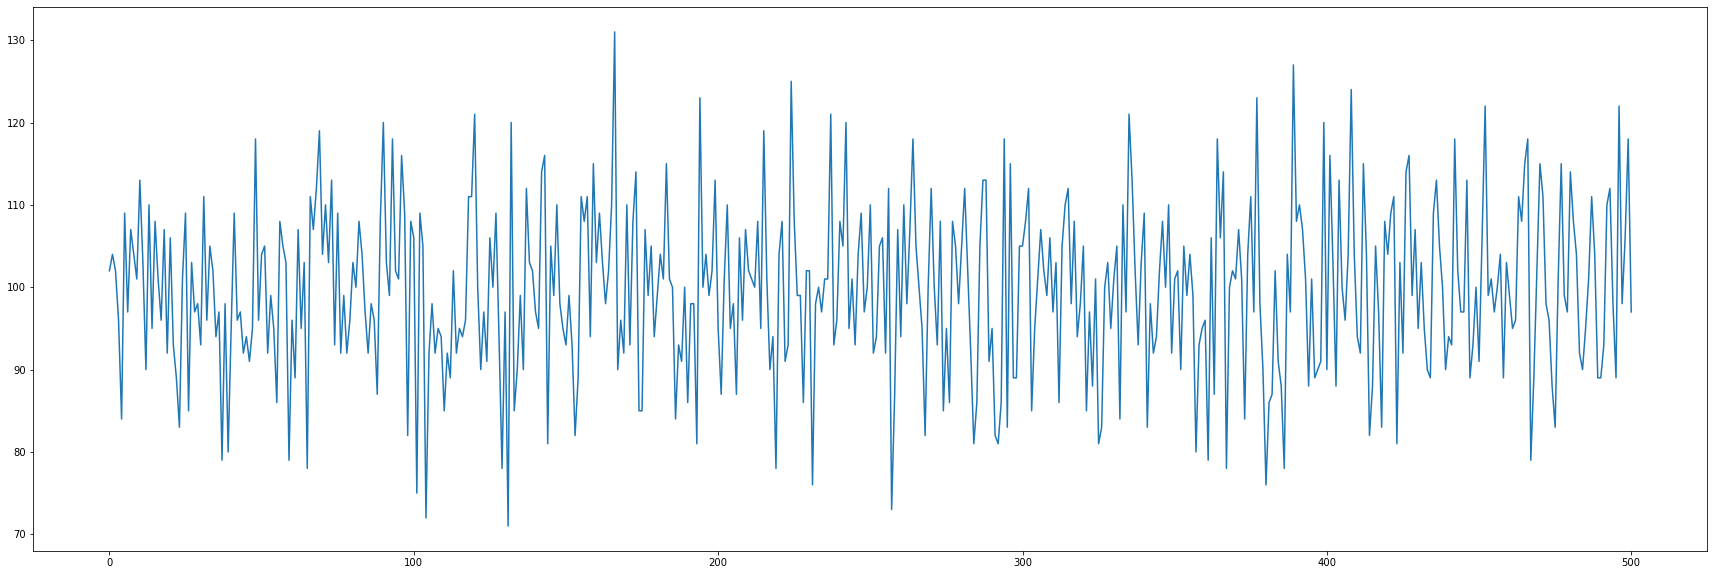

In [96]:
plt.figure(figsize=(30, 10))
plt.plot(all_precense_time[::200])

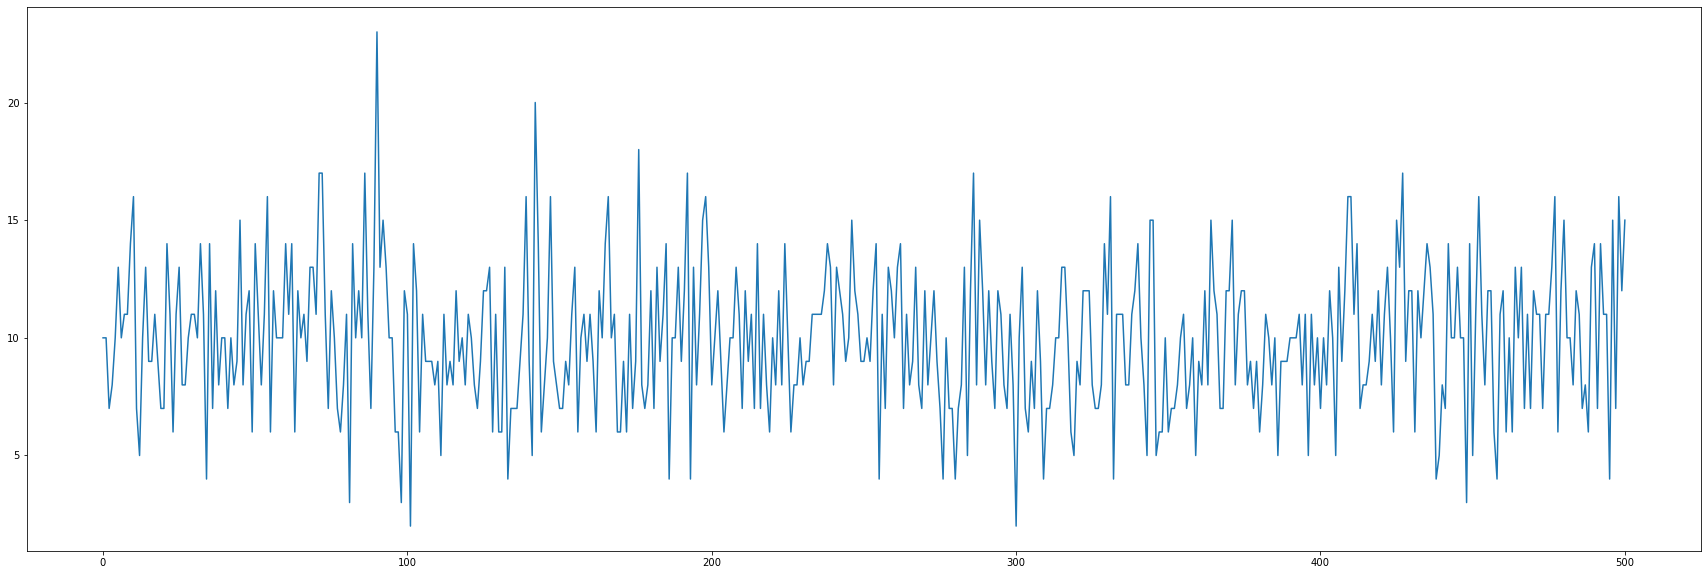

In [98]:
plt.figure(figsize=(30, 10))
plt.plot(corona_precense_time[::200])

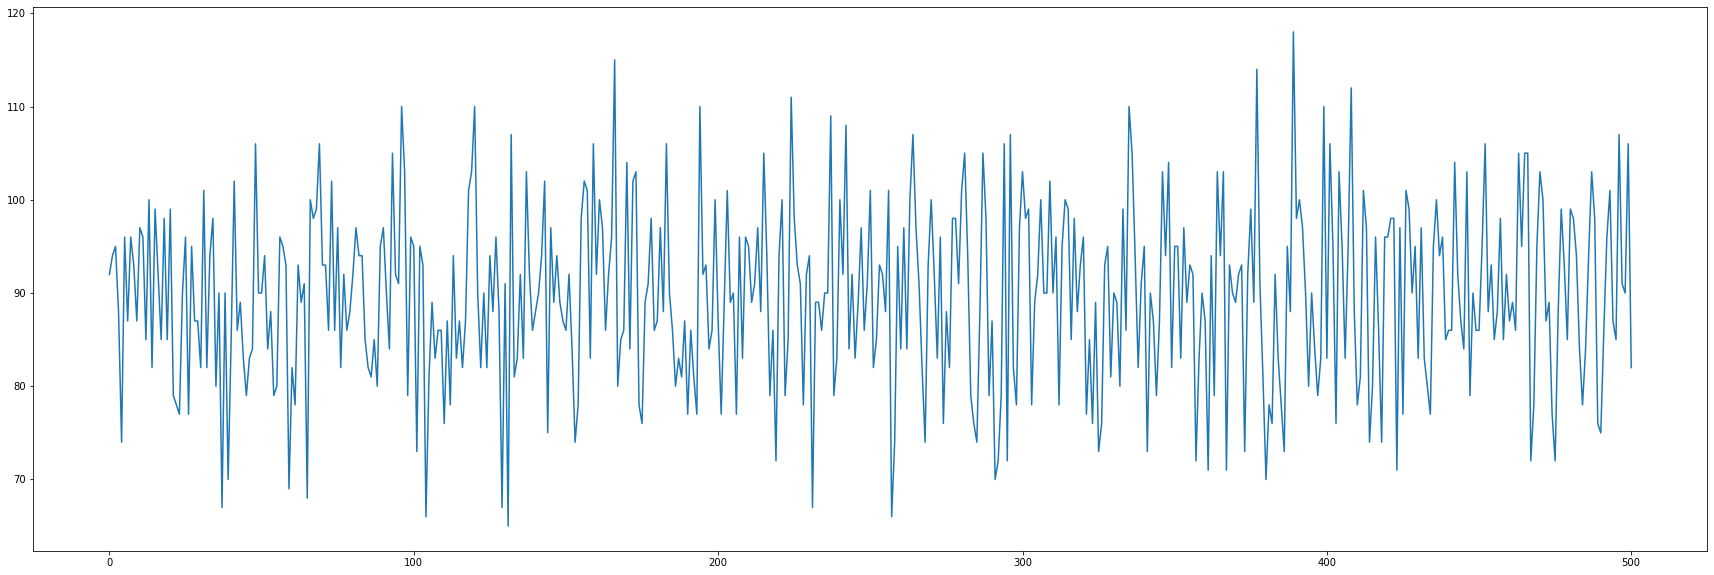

In [99]:
plt.figure(figsize=(30, 10))
plt.plot(precense_time[::200])